In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_yt = pd.read_csv("youtube_recommendation_dataset -.csv")
df_yt.head()

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,PT1M51S,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,PT1M,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,PT18M2S,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,PT3M23S,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,PT3M35S,hd,True,0.077768,0.069856,0.007912,215,0


In [3]:
df_yt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    537 non-null    object 
 1   channel_title            537 non-null    object 
 2   published_at             537 non-null    object 
 3   category_id              537 non-null    int64  
 4   view_count               537 non-null    int64  
 5   like_count               537 non-null    int64  
 6   comment_count            537 non-null    int64  
 7   favorite_count           537 non-null    int64  
 8   duration                 537 non-null    object 
 9   definition               537 non-null    object 
 10  caption                  537 non-null    bool   
 11  engagement_rate          537 non-null    float64
 12  likes_to_views_ratio     537 non-null    float64
 13  comments_to_views_ratio  537 non-null    float64
 14  duration_seconds         5

In [4]:
df_yt['Title'] = df_yt['Title'].astype('string')
df_yt['channel_title'] = df_yt['channel_title'].astype('string')
df_yt['published_at'] = pd.to_datetime(df_yt['published_at'])
df_yt['duration'] = pd.to_timedelta(df_yt['duration'])

In [5]:
df_yt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Title                    537 non-null    string             
 1   channel_title            537 non-null    string             
 2   published_at             537 non-null    datetime64[ns, UTC]
 3   category_id              537 non-null    int64              
 4   view_count               537 non-null    int64              
 5   like_count               537 non-null    int64              
 6   comment_count            537 non-null    int64              
 7   favorite_count           537 non-null    int64              
 8   duration                 537 non-null    timedelta64[ns]    
 9   definition               537 non-null    object             
 10  caption                  537 non-null    bool               
 11  engagement_rate          537 non

In [6]:
df_yt.head()

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,0 days 00:01:51,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,0 days 00:18:02,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,True,0.077768,0.069856,0.007912,215,0


In [7]:
df_cap_true=df_yt[df_yt['caption']==True]
df_cap_true

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,True,0.077768,0.069856,0.007912,215,0
7,Wake Up Dead Man: A Knives Out Mystery | Offic...,Netflix,2025-11-17 14:00:00+00:00,24,1925626,34578,1248,0,0 days 00:02:03,hd,True,0.018605,0.017957,0.000648,123,0
13,IT: Welcome to Derry | Midseason Trailer | HBO...,HBO Max,2025-11-17 03:00:38+00:00,24,599589,24027,1424,0,0 days 00:01:34,hd,True,0.042447,0.040072,0.002375,94,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,Dinosaur Game Ads Review 73 All Levels: Thrill...,Dino Review,2024-12-03 08:00:02+00:00,20,1578986,4419,6,0,0 days 00:15:18,hd,True,0.002802,0.002799,0.000004,918,350
530,Elin Review | Taxation Not Optional™,SsethTzeentach,2025-07-30 17:25:26+00:00,20,1571887,100532,3978,0,0 days 00:13:44,hd,True,0.066487,0.063956,0.002531,824,110
531,Game of The Year 2025 is Going To Be A RIDICUL...,gameranx,2025-09-17 16:46:31+00:00,20,1596531,33624,7932,0,0 days 00:19:15,hd,True,0.026029,0.021061,0.004968,1155,61
532,Ghost of Yotei - Before You Buy,gameranx,2025-09-25 21:41:42+00:00,20,1366391,45978,9598,0,0 days 00:13:16,hd,True,0.040674,0.033649,0.007024,796,53


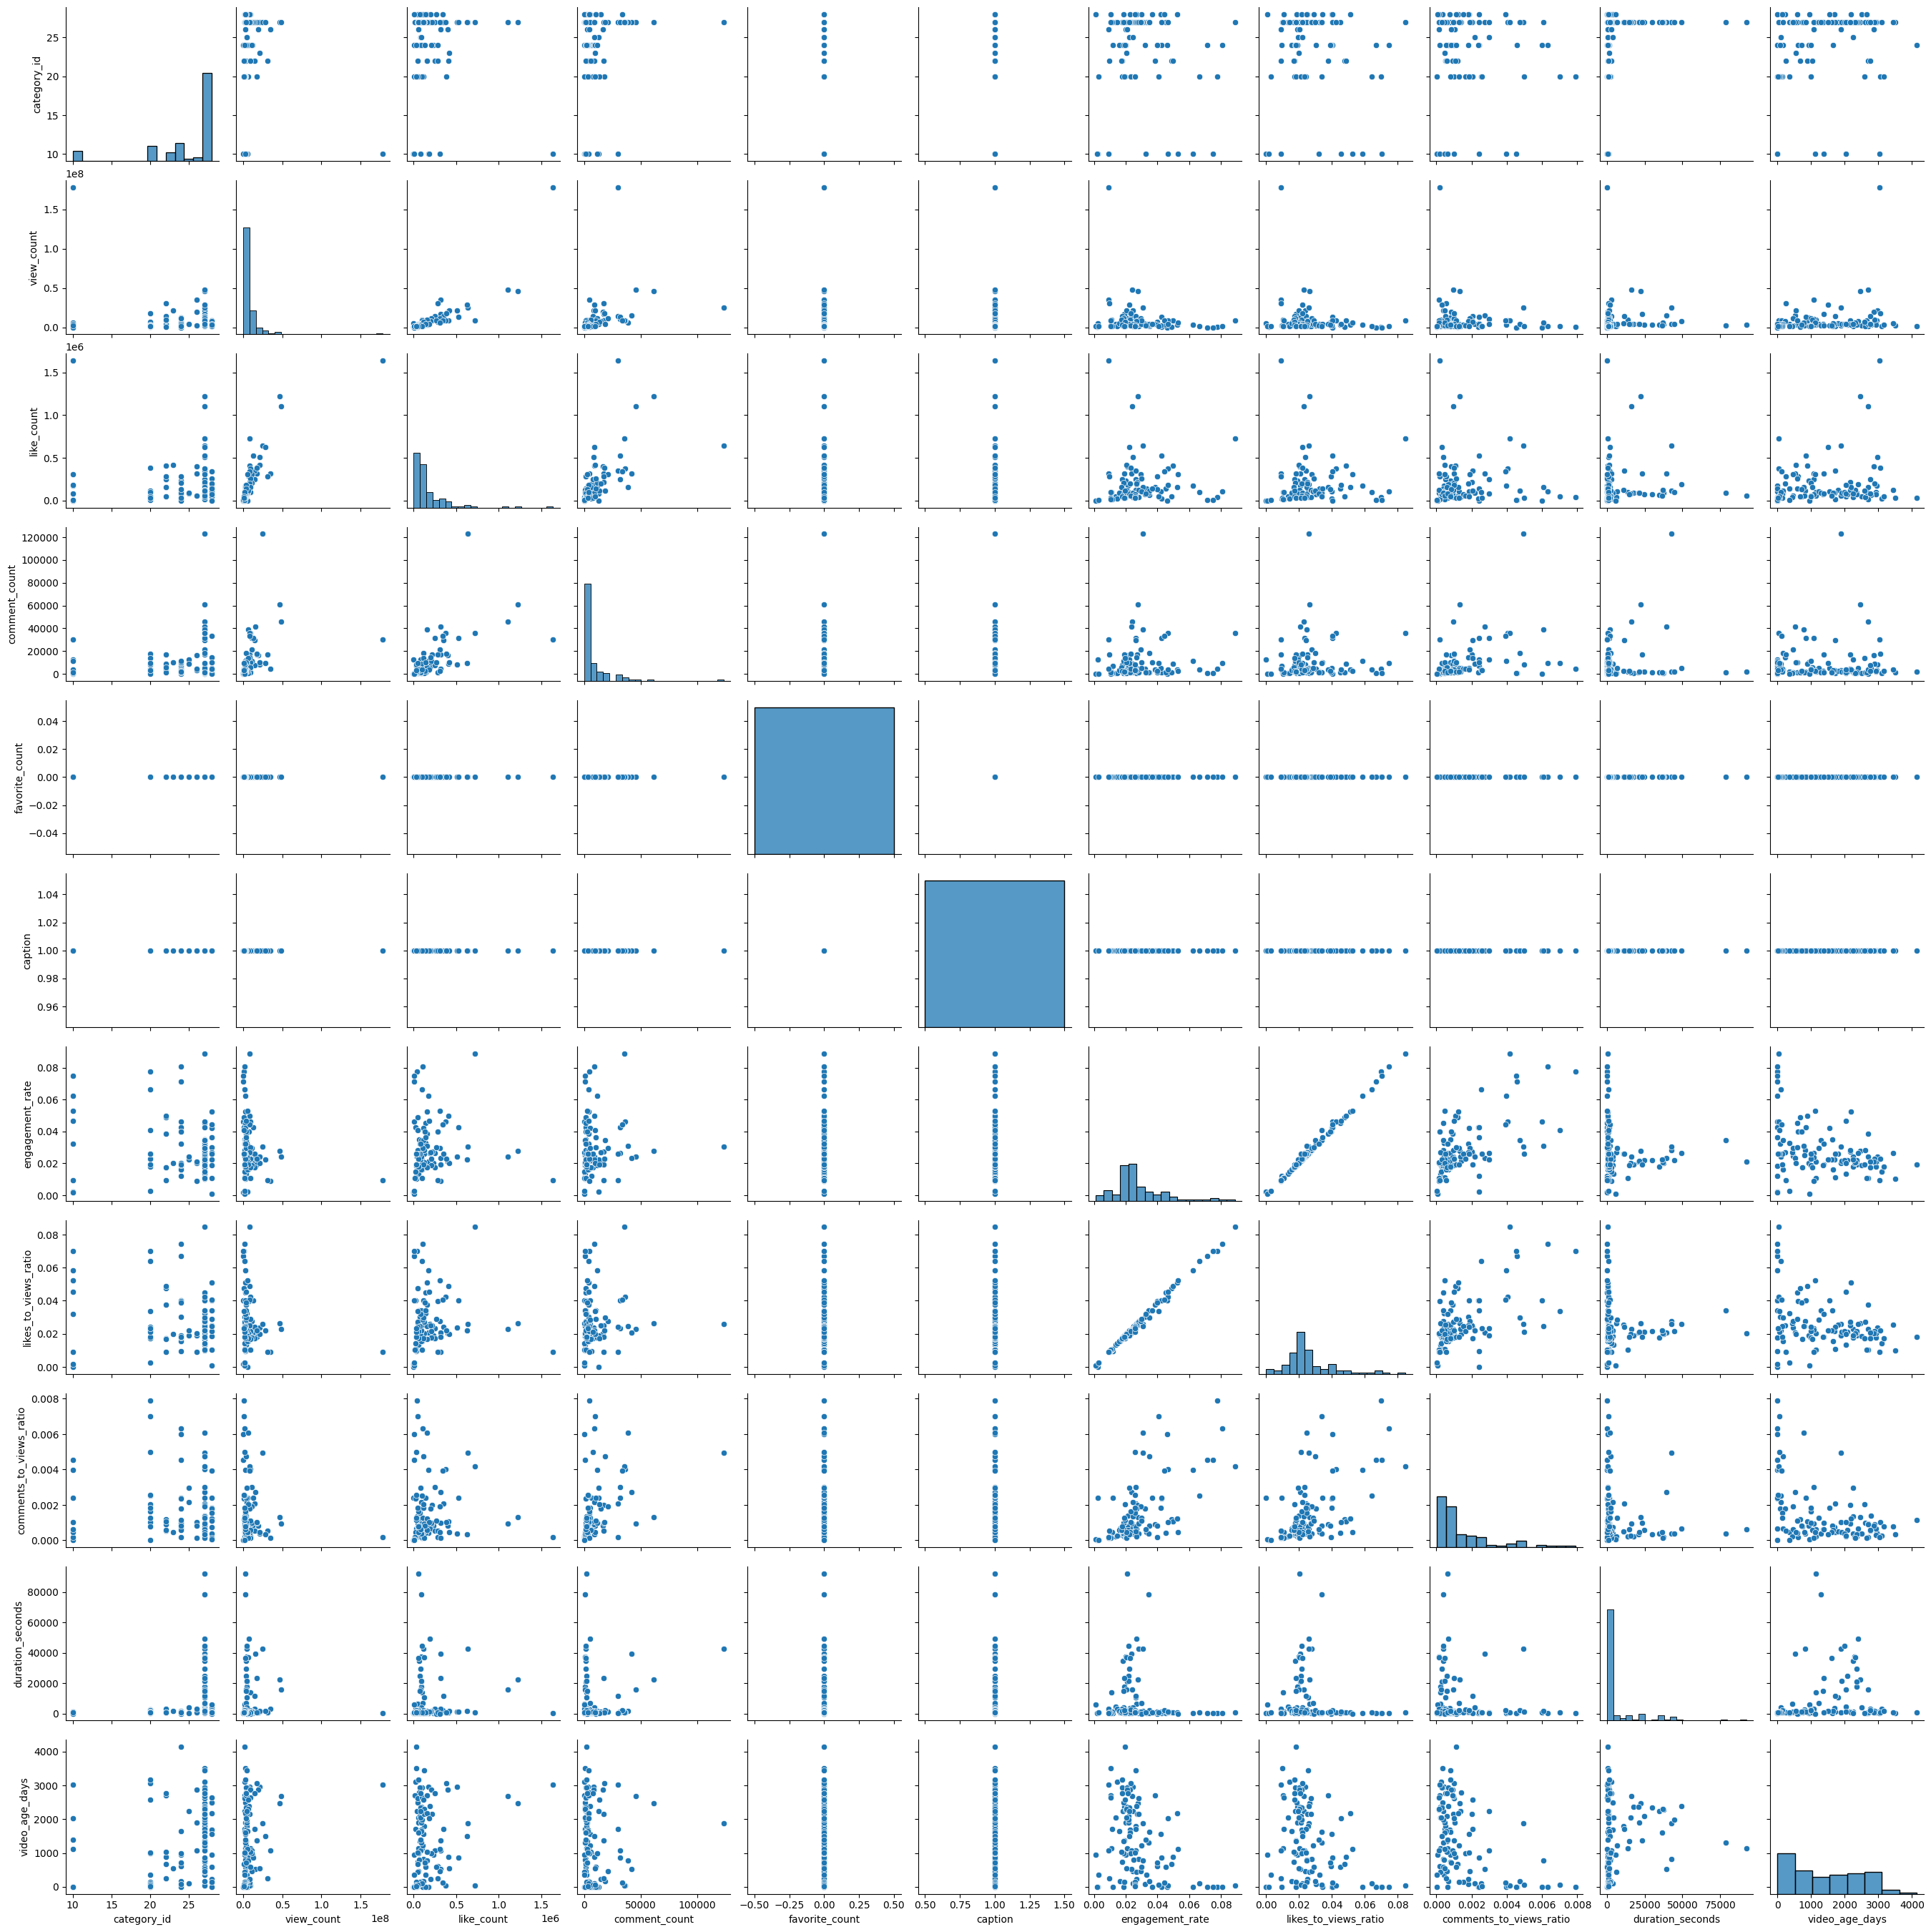

In [8]:
sns.pairplot(df_cap_true)

In [9]:
netflix_disney_df = df_yt[df_yt['channel_title'].isin(['Netflix', 'Disney'])]
netflix_disney_df

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60,0
7,Wake Up Dead Man: A Knives Out Mystery | Offic...,Netflix,2025-11-17 14:00:00+00:00,24,1925626,34578,1248,0,0 days 00:02:03,hd,True,0.018605,0.017957,0.000648,123,0


In [10]:
channel_counts_df = df_cap_true['channel_title'].value_counts().reset_index()
channel_counts_df.columns = ['channel_title', 'count']

channel_counts_df

,channel_title,count
0,freeCodeCamp.org,16
1,CodeWithHarry,9
2,3Blue1Brown,6
3,edureka!,4
4,AI Warehouse,4
...,...,...
63,Edward Smith,1
64,IGN,1
65,LGR,1
66,Dino Review,1


In [11]:
freecode_harry = df_yt[df_yt['channel_title'].isin(['freeCodeCamp.org', 'CodeWithHarry'])]
freecode_harry

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
56,Machine Learning for Everybody – Full Course,freeCodeCamp.org,2022-09-26 16:00:28+00:00,27,9342497,98679,2163,0,0 days 03:53:53,hd,True,0.010794,0.010562,0.000232,14033,1148
64,Learn Data Science Tutorial - Full Course for ...,freeCodeCamp.org,2019-05-30 12:48:19+00:00,27,4231800,87338,1383,0,0 days 05:52:09,hd,True,0.020965,0.020638,0.000327,21129,2363
65,Harvard CS50’s Artificial Intelligence with Py...,freeCodeCamp.org,2023-08-10 14:17:52+00:00,27,4222472,117312,1659,0,0 days 11:51:22,hd,True,0.028176,0.027783,0.000393,42682,830
73,TensorFlow 2.0 Complete Course - Python Neural...,freeCodeCamp.org,2020-03-03 15:44:00+00:00,27,3402554,72326,1991,0,0 days 06:52:08,hd,True,0.021842,0.021256,0.000585,24728,2085
74,PyTorch for Deep Learning & Machine Learning –...,freeCodeCamp.org,2022-10-06 14:13:05+00:00,27,2941564,59903,1812,0,1 days 01:37:26,hd,True,0.020980,0.020364,0.000616,92246,1138
83,Prompt Engineering Tutorial – Master ChatGPT a...,freeCodeCamp.org,2023-09-05 14:36:07+00:00,27,2439346,60236,1084,0,0 days 00:41:36,hd,True,0.025138,0.024693,0.000444,2496,804
86,Machine Learning Course for Beginners,freeCodeCamp.org,2021-08-30 13:23:10+00:00,27,1933887,55410,1397,0,0 days 09:52:19,hd,False,0.029375,0.028652,0.000722,35539,1540
100,Learn Python - Full Course for Beginners [Tuto...,freeCodeCamp.org,2018-07-11 18:00:42+00:00,27,48004241,1108112,45864,0,0 days 04:26:52,hd,True,0.024039,0.023084,0.000955,16012,2686
102,Python Tutorial For Beginners In Hindi (With N...,CodeWithHarry,2020-09-24 11:34:17+00:00,27,24863726,640459,122906,0,0 days 11:52:24,hd,True,0.030702,0.025759,0.004943,42744,1880
106,Python Tutorial For Beginners in Hindi | Compl...,CodeWithHarry,2024-06-16 05:36:24+00:00,27,15268966,315818,41749,0,0 days 10:53:55,hd,True,0.023418,0.020684,0.002734,39235,520


<Axes: xlabel='view_count', ylabel='Count'>

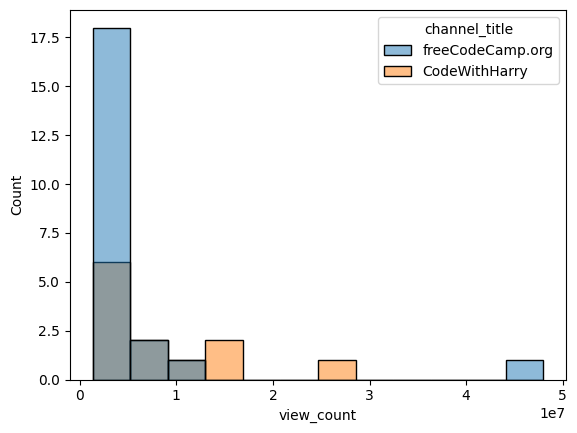

In [12]:
sns.histplot(freecode_harry, x="view_count",hue="channel_title")

<Axes: xlabel='channel_title', ylabel='view_count'>

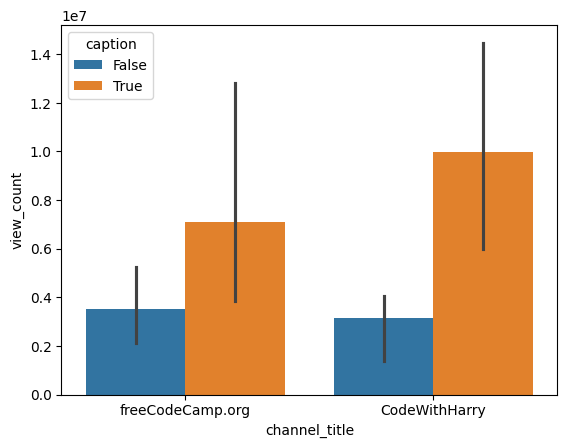

In [13]:
sns.barplot(freecode_harry,x="channel_title",y="view_count",hue="caption")

In [14]:
df_yt

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,0 days 00:01:51,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,0 days 00:18:02,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,True,0.077768,0.069856,0.007912,215,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,Ghost of Yotei - Before You Buy,gameranx,2025-09-25 21:41:42+00:00,20,1366391,45978,9598,0,0 days 00:13:16,hd,True,0.040674,0.033649,0.007024,796,53
533,"₹50,000 PS5 vs ₹2000 Game Stick 😲🤯 Who is the ...",Digidoty,2024-11-08 11:49:56+00:00,28,1576718,32917,327,0,0 days 00:00:46,hd,False,0.021084,0.020877,0.000207,46,374
534,Arc Raiders - Before You Buy,gameranx,2025-10-31 21:57:47+00:00,20,1218921,28356,3146,0,0 days 00:14:14,hd,True,0.025844,0.023263,0.002581,854,17
535,Clair Obscur: Expedition 33 Review,IGN,2025-04-23 09:00:23+00:00,20,1220485,16187,2947,0,0 days 00:17:48,hd,False,0.015677,0.013263,0.002415,1068,209


In [15]:
df_yt.head()

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,0 days 00:01:51,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,0 days 00:18:02,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,True,0.077768,0.069856,0.007912,215,0


In [19]:
corr_yt=df_yt[['view_count','like_count','comment_count']]

In [20]:
corr_yt

,view_count,like_count,comment_count
0,1405647,140463,9063
1,2776847,26801,6684
2,1189857,16174,1827
3,5319161,0,12869
4,597542,41742,4728
...,...,...,...
532,1366391,45978,9598
533,1576718,32917,327
534,1218921,28356,3146
535,1220485,16187,2947


In [21]:
corr=corr_yt.corr()
corr

,view_count,like_count,comment_count
view_count,1.000000,0.818828,0.062265
like_count,0.818828,1.000000,0.082426
comment_count,0.062265,0.082426,1.000000


In [22]:
import seaborn as sns

<Axes: >

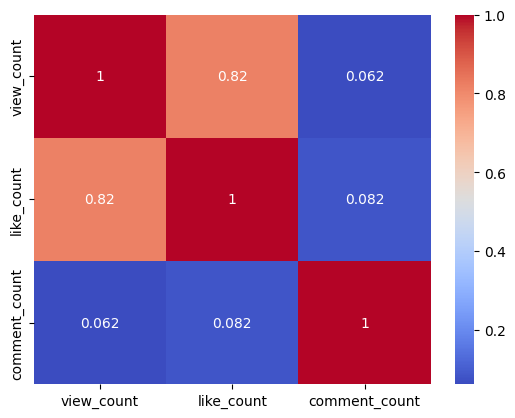

In [23]:
sns.heatmap(corr,annot=True,cmap='coolwarm')

In [ ]:
captrue=df_yt.groupby('caption').agg({'view_count':'mean'})
captrue.round(2)

,view_count
caption,
False,25026927.82
True,8359336.72


In [33]:
df_yt.head(10)

,Title,channel_title,published_at,category_id,view_count,like_count,comment_count,favorite_count,duration,definition,caption,engagement_rate,likes_to_views_ratio,comments_to_views_ratio,duration_seconds,video_age_days
0,LA PERVERSA X LA INSUPERABLE X ALOFOKE MUSIC X...,AlofokeMusicSounds,2025-11-16 15:34:55+00:00,10,1405647,140463,9063,0,0 days 00:01:51,hd,False,0.106375,0.099928,0.006448,111,1
1,Moana | Official Teaser,Disney,2025-11-17 17:00:47+00:00,24,2776847,26801,6684,0,0 days 00:01:00,hd,True,0.012059,0.009652,0.002407,60,0
2,$0 - $1 Trillion Only FISHING in Steal a Brain...,CaylusBlox,2025-11-17 22:57:14+00:00,20,1189857,16174,1827,0,0 days 00:18:02,hd,False,0.015129,0.013593,0.001535,1082,0
3,ALLDAY PROJECT - ‘ONE MORE TIME’ M/V,THEBLACKLABEL,2025-11-17 09:00:07+00:00,10,5319161,0,12869,0,0 days 00:03:23,hd,True,0.002419,0.000000,0.002419,203,1
4,La Lupa | Vendetta Hero Trailer | Overwatch 2,PlayOverwatch,2025-11-17 17:00:06+00:00,20,597542,41742,4728,0,0 days 00:03:35,hd,True,0.077768,0.069856,0.007912,215,0
5,I Shouldn’t Have Went Christmas Shopping…,CaseOh,2025-11-17 23:01:11+00:00,20,296652,10565,676,0,0 days 01:13:51,hd,False,0.037893,0.035614,0.002279,4431,0
6,Charli xcx - Chains of Love (Official Video),Charli xcx,2025-11-17 17:00:56+00:00,10,333414,33124,1778,0,0 days 00:03:13,hd,False,0.104680,0.099348,0.005333,193,0
7,Wake Up Dead Man: A Knives Out Mystery | Offic...,Netflix,2025-11-17 14:00:00+00:00,24,1925626,34578,1248,0,0 days 00:02:03,hd,True,0.018605,0.017957,0.000648,123,0
8,It's all crashing down..,Asmongold TV,2025-11-18 02:00:35+00:00,20,755718,26231,5285,0,0 days 00:17:13,hd,False,0.041703,0.034710,0.006993,1033,0
9,DeeBaby - Pain Gon Come ( Official Music Vid...,Official DeeBabyTV,2025-11-17 19:00:57+00:00,10,92297,4674,306,0,0 days 00:02:56,hd,False,0.053956,0.050640,0.003315,176,0


In [35]:
df_yt['engagement_rate'].describe()

count    537.000000
mean       0.028722
std        0.020608
min        0.000000
25%        0.015579
50%        0.024368
75%        0.037366
max        0.215744
Name: engagement_rate, dtype: float64